# Example of Parallelizing Pfof usage - 2MRS version

## Import Packages 

In [ ]:
# All of Friends of Friends 
import FOF
import save_field
import region_merging
import numpy as np 
import astropy.cosmology 
import astropy.units as u
import pandas as pd
import glob
from astropy.cosmology import FlatLambdaCDM , Planck18
import time
from pydl.goddard.astro import gcirc
import astropy.units as u
import ray
# declare ray instance for selecting number of cpu about usage
ray.init(num_cpus=5)
from tqdm import trange
import sys
import Group_Summary
# recrusive depth option
sys.setrecursionlimit(10**6)

# upload file 

###   As in the example below, you should set the column names to match the pandas dataframe 

-  example file is from 2MRS_add_distance data hdf file format.
-  Dataframe column "ra","dec","redshift". ( ex) RA x, Ra x, ra o) It must be distinguished uppercase and lowercase.
-  At least redshift should be greater than $10^{-3}$

In [2]:
dir1 =  "/data/ehddbs98/fof_file/CNU_fof_functions/"
df = pd.read_hdf(dir1+"2MRS_add_distance.hdf")
MKC = df['MKC']

df['ra'] = df['RA']
df['dec'] = df['DEC']
df['redshift'] = df['z']
df['ID'] = np.arange(0,len(df['redshift']))
df.drop(df[(df['z'] <= 10**(-2))].index,inplace=True)

In [8]:
df

,TMID,RA,DEC,MKC,V,EV,z,distance,GLON,GLAT,...,abs,Lc,Mh,EKC,Mk-5logh,WKC,ra,dec,redshift,ID
797,14585625-4200482,224.734436,-42.013371,8.677,2998,5,0.010000,44.218289,326.880127,14.853280,...,-24.546856,1.556979e+12,17.044179,0.030,-22.706856,0.970,224.734436,-42.013371,0.010000,3192
3035,05431530-3004420,85.813789,-30.078390,9.756,2998,19,0.010000,44.218289,234.700638,-27.019051,...,-23.467856,5.763457e+11,15.133379,0.041,-21.627856,0.959,85.813789,-30.078390,0.010000,3193
22205,06220134-1353273,95.505577,-13.890920,11.242,2999,35,0.010004,44.233038,222.194031,-12.712220,...,-21.982583,1.467485e+11,13.419309,0.073,-20.142583,0.927,95.505577,-13.890920,0.010004,3194
20646,05045140+0149527,76.214119,1.831250,11.188,3001,0,0.010010,44.262537,198.324066,-22.603649,...,-22.038036,1.544383e+11,13.469050,0.076,-20.198036,0.924,76.214119,1.831250,0.010010,3195
1559,11454556+1049286,176.439880,10.824610,9.245,3001,2,0.010010,44.262537,256.322418,67.538544,...,-23.981036,9.246022e+11,15.955804,0.025,-22.141036,0.975,176.439880,10.824610,0.010010,3196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34900,13000533+1632151,195.022263,16.537479,11.583,23961,5,0.079925,353.407080,314.085693,79.221321,...,-26.204256,7.165446e+12,21.739033,0.039,-24.364256,0.961,195.022263,16.537479,0.079925,43046
29307,19541472+1002550,298.561401,10.048640,11.448,23967,35,0.079945,353.495575,49.210159,-9.067670,...,-26.339813,8.118311e+12,22.252161,0.089,-24.499813,0.911,298.561401,10.048640,0.079945,43047
33726,12191007-0501122,184.791946,-5.020140,11.557,23968,37,0.079949,353.510324,288.091400,56.918819,...,-26.230905,7.343493e+12,21.838060,0.068,-24.390905,0.932,184.791946,-5.020140,0.079949,43048
24274,13215602-2738305,200.483383,-27.641880,11.308,23980,45,0.079989,353.687316,311.154846,34.742470,...,-26.481017,9.245864e+12,22.812255,0.074,-24.641017,0.926,200.483383,-27.641880,0.079989,43049


## From functions executing savefile
### This function divdes the regions and also divdes the common area

- My directory is dir2 
- The argument order of the function save file is as follows. 
 1. The number to be divded in the ra
 2. The number to be divded in the dec 
 3. Hubble constant 
 4. Dark matter Density paramter 
 5. To save file directory 
 
The output value is the maximum value of the angular distance, which is half the length of the common field in the dec direction 

### When the cell is executed, there will be files in which the particles are stored for each section in the directory you specify 

### cosmological parameters, light speed, linking length and nmin values must be set. 

In [5]:
H0 = 67.7          # Hubble parameter
omegamc = 0.3      # Matter parameter
omegalc = 0.7      # Dark Energy parameter 
omegakc = 0        # curverture Term 
c =2.998*10**5     # light speed        
dcondc = 500   # linking length (ra,dec)
vcondc = 1000    # linking length (linear direction)
nmin = 2           # minimum value of particles per group

In [6]:
# x = np.arange(70,171,10)
# a = 1800
# k = 0 
# for i in x:
#     k += ((4/3*np.pi*((i+10)**3-i**3))/a)**(1/3)
# print(np.mean(k))

In [10]:
dir2 =  "/data/ehddbs98/fof_file/field_file2/"
save_field.save_file(df,0,5,67.7,0.3,dcondc,dir2)

linkling_angular is 0.6548646448087999 [degree]
total divided field : 6


In [11]:
print(np.loadtxt(dir2+"field_1"))

[[  2.24734436e+02  -4.20133705e+01   1.00002516e-02   3.19200000e+03]
 [  8.58137894e+01  -3.00783901e+01   1.00002516e-02   3.19300000e+03]
 [  3.16366333e+02  -5.25519600e+01   1.00102585e-02   3.19800000e+03]
 ..., 
 [  8.38604736e+01  -2.36004391e+01   7.97151475e-02   4.30390000e+04]
 [  3.37116608e+02  -2.44610291e+01   7.97318257e-02   4.30400000e+04]
 [  2.00483383e+02  -2.76418800e+01   7.99886700e-02   4.30490000e+04]]


In [12]:
a = glob.glob(dir2+"field_*")
for i in range(len(a)):
    field = np.loadtxt(a[i])
    print(min(field[:,1]))
    print(max(field[:,1]))

-88.9871902466
-53.1901397705
-54.4953918457
-18.0617809296
-19.3639907837
17.0892696381
15.7825899124
52.2299880981
50.9343605042
87.2752075195
86.1953201294
89.0931930542


## Call the file name 

The area divded in the save file is designated as "field_*", and the common areas are designated as "common_*"

In [14]:
parallel_field_file = glob.glob(dir2+"field_*")
whole_file = np.array([df['ra'],df['dec'],df['redshift'],df['ID']]).T
np.savetxt(dir2+'2mrs_data',whole_file)
whole_field_file = glob.glob(dir2+"2mrs_data")

### To run the parallelized code, you need to do the following: The remote function is a function that receives the result value from ray at once. 

**caution) In the example, if "start" does appear at once, it is a problem with the number of cores or the ray version. 
Use a version close to the version introduced in the Readme.**

In [15]:
whole_result = [FOF.mainloop.remote(whole_field_file[0],H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin)]
whole_results = ray.get(whole_result)

(mainloop pid=703088) start
(mainloop pid=703088) 2.0 mins 4.0 second


In [17]:
# print(len(whole_results[0]))
# idx1 = nmin_cut(whole_results[0],4)


In [18]:
%%time
result = [FOF.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in parallel_field_file]
parallel_results = ray.get(result)

(mainloop pid=703088) start
(mainloop pid=703087) start
(mainloop pid=703090) start
(mainloop pid=703086) start
(mainloop pid=703089) start
(mainloop pid=703088) 0.0 mins 1.0 second
(mainloop pid=703088) start
(mainloop pid=703088) 0.0 mins 0.0 second
(mainloop pid=703087) 0.0 mins 1.0 second
(mainloop pid=703089) 0.0 mins 8.0 second
(mainloop pid=703090) 0.0 mins 11.0 second
CPU times: user 36.4 ms, sys: 29.8 ms, total: 66.2 ms
Wall time: 14 s
(mainloop pid=703086) 0.0 mins 13.0 second


### Merge divded field and common field found with fof

In [22]:
result= region_merging.renew_region_merging(parallel_results[0],parallel_results[1])
for i in range(1,len(parallel_results)-1):
    result= region_merging.renew_region_merging(result,parallel_results[i+1])

In [36]:
# numpy array to pandas dataframe 
df_result = pd.DataFrame({'ID':result[:,0],'ra':result[:,1],'dec':result[:,2],'redshift':result[:,3],'Gname':result[:,4]})

In [38]:
from tqdm import trange
# Finding the number of each groups. 
result_num= np.zeros(len(result))+-1
group = np.unique(result[:,4])
for i in trange(len(result_num)):
    if result_num[i] != -1:
        continue
    idx = np.where(result[:,4] == result[:,4][i])[0]
    result_num[idx] = int(idx.size)
df_result['Gnum'] = result_num
df_result

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13645/13645 [00:00<00:00, 135378.86it/s]


,ID,ra,dec,redshift,Gname,Gnum
0,3193.0,85.813789,-30.078390,0.010000,3193.0,2.0
1,3199.0,195.453125,-27.125080,0.010014,3199.0,3.0
2,3202.0,268.999115,18.338261,0.010017,3202.0,4.0
3,3205.0,199.749725,-47.908661,0.010024,3205.0,2.0
4,3208.0,109.988777,-63.067020,0.010030,3208.0,2.0
...,...,...,...,...,...,...
13640,42914.0,323.573853,-53.636238,0.076520,42914.0,2.0
13641,42983.0,314.747742,31.327930,0.078328,42983.0,2.0
13642,42993.0,323.527832,-53.571869,0.078571,42914.0,2.0
13643,43003.0,230.335663,30.670950,0.078821,42876.0,2.0


### Result 

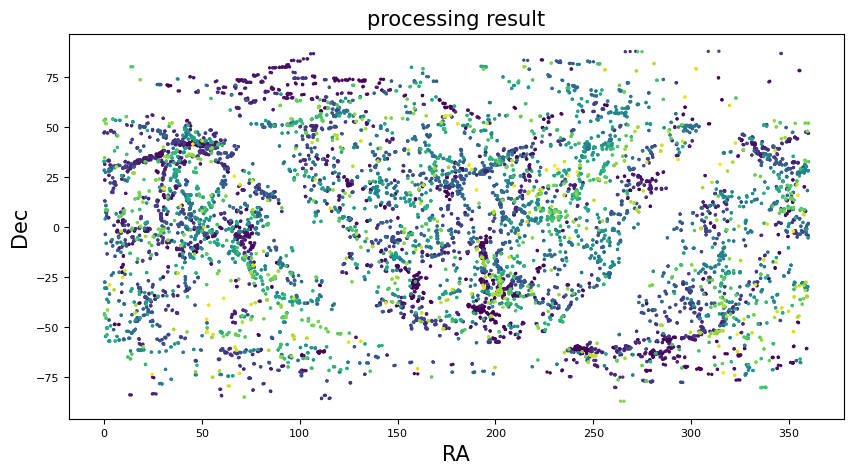

The number of finding particle : 13645


In [39]:
fig = plt.figure(figsize=(10,5))
plt.scatter(result[:,1],result[:,2],s=2,cmap='viridis',c=result[:,4])
plt.xlabel("RA",fontsize=15)
plt.ylabel('Dec',fontsize=15)
plt.title("processing result",fontsize=15)
plt.show()

print("The number of finding particle :",len(result[:,0]))

In [40]:
# Input : Unique_ID, Ra,Dec,Redshift, Group_ID 
def nmin_cut(result,nmin):
    result_copy = result.copy()
    
    uni_group = np.unique(result_copy[:,4])
    for idx,val in enumerate(uni_group):
        find = np.where(result_copy[:,4] == val)[0]
        if find.size < nmin:
            result_copy = np.delete(result_copy,find,axis=0)
    print("Total Number of Galaxies  :", len(result_copy[:,0]))
    print("Total Number of Finding Groups :", len(np.unique(result_copy[:,4])))
    return result_copy 

In [41]:
def group_summary(result):
    # fname,fra,fdec,fredshift,fnum
    uni_group = np.unique(result[:,4])
    gsum = np.zeros([5,len(uni_group)]).T
    
    
    for idx,val in enumerate(uni_group):
        find = np.where(result[:,4] == val)[0]
        
        
        f_ra = np.mean(result[:,1][find])
        f_dec = np.mean(result[:,2][find])
        f_redshift = np.mean(result[:,3][find])
        f_ID = val 
        f_num = len(find)
        
        gsum[idx] = np.array([f_ID,f_ra,f_dec,f_redshift,f_num])
    
    relabeling = np.arange(1,len(uni_group))
    
    nmin_col = gsum[:,4]
    
    sorted_indices = np.argsort(nmin_col)[::-1]
    sorted_gsum = gsum[sorted_indices]
    
    relabeling_gname = np.arange(1,len(nmin_col)+1)
    for idx,val in enumerate(relabeling_gname):
        sorted_gsum[:,0][idx] = val
    
    return sorted_gsum

In [42]:
# nmin(4) cut group 
gsum = Group_Summary.nmin_cut(result,4)
gsum_2 = Group_Summary.group_summary(gsum)
np.savetxt(dir1+'/2rms_group_summary',gsum_2) # dir1 is your input data directory 

Total Number of Galaxies  : 5229
Total Number of Finding Groups : 730


In [43]:
print(len(result))
new_result = nmin_cut(result,4)
new2_result = group_summary(new_result)

13645
Total Number of Galaxies  : 5229
Total Number of Finding Groups : 730


In [44]:
df_result

,ID,ra,dec,redshift,Gname,Gnum
0,3193.0,85.813789,-30.078390,0.010000,3193.0,2.0
1,3199.0,195.453125,-27.125080,0.010014,3199.0,3.0
2,3202.0,268.999115,18.338261,0.010017,3202.0,4.0
3,3205.0,199.749725,-47.908661,0.010024,3205.0,2.0
4,3208.0,109.988777,-63.067020,0.010030,3208.0,2.0
...,...,...,...,...,...,...
13640,42914.0,323.573853,-53.636238,0.076520,42914.0,2.0
13641,42983.0,314.747742,31.327930,0.078328,42983.0,2.0
13642,42993.0,323.527832,-53.571869,0.078571,42914.0,2.0
13643,43003.0,230.335663,30.670950,0.078821,42876.0,2.0


# 2MRS HEALPY Plot

<Figure size 1200x600 with 0 Axes>

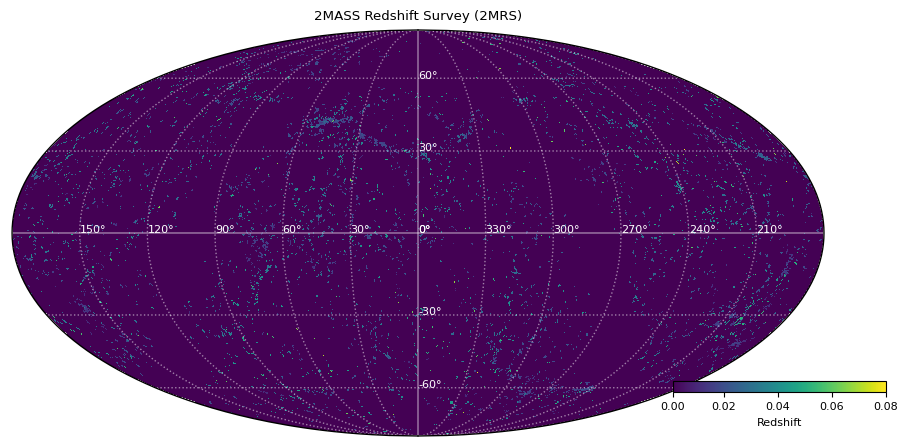

In [55]:
import healpy as hp


plt.rcParams['font.size'] = 8
nside = 128
npix = hp.nside2npix(nside)
ra = df_result['ra'].values
dec = df_result['dec'].values
redshift = df_result['redshift'].values


theta = np.radians(90.0 - dec)
phi = np.radians(ra)
pixels = hp.ang2pix(nside, theta, phi)

fig = plt.figure(figsize=(12, 6))
hpx_map = np.zeros(npix)
for pix, z in zip(pixels, redshift):
    hpx_map[pix] = max(hpx_map[pix], z)

hp.mollview(hpx_map, title="2MASS Redshift Survey (2MRS)", unit='Redshift', cmap='viridis', min=0.001, max=0.08, cbar=False)
for ra in range(0, 360, 30):
    hp.projtext(np.pi/2, np.radians(ra), "{}°".format(ra), lonlat=False, coord='C', color="w")

for dec in range(-60, 90, 30):
    hp.projtext(np.radians(90-dec), 0, "{}°".format(dec), lonlat=False, coord='C', color="w")

axes = plt.gca()  
image = axes.get_images()[0] 
cbar = plt.colorbar(image, ax=axes, orientation='horizontal', pad=0.01, fraction=0.04)
cbar.set_label('Redshift')

cbar.ax.set_position([0.8, 0.1, 0.25, 0.1])  # [left, bottom, width, height]

    
hp.graticule(color="white",alpha=0.5)
plt.show()
